# Titanic -- predict survivors

We will have to predict if a passenger has survived the titanic wreckage

## Preliminary stuff

Let's import packages and set warnings off

In [1]:
# imports and routine stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['dark_background'])
import warnings
warnings.filterwarnings('ignore')

## data exploration

Let's load and check the data

In [2]:
## data paths
#gender = "./dataset/titanic/data/gender_submission.csv" it's just an example of result submission file
train = "./dataset/titanic/data/train.csv"
test = "./dataset/titanic/data/test.csv" 
## 
#gender_df = pd.read_csv(gender)
train_df = pd.read_csv(train)
test_df = pd.read_csv(test)
##
train_df.shape

(891, 12)

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


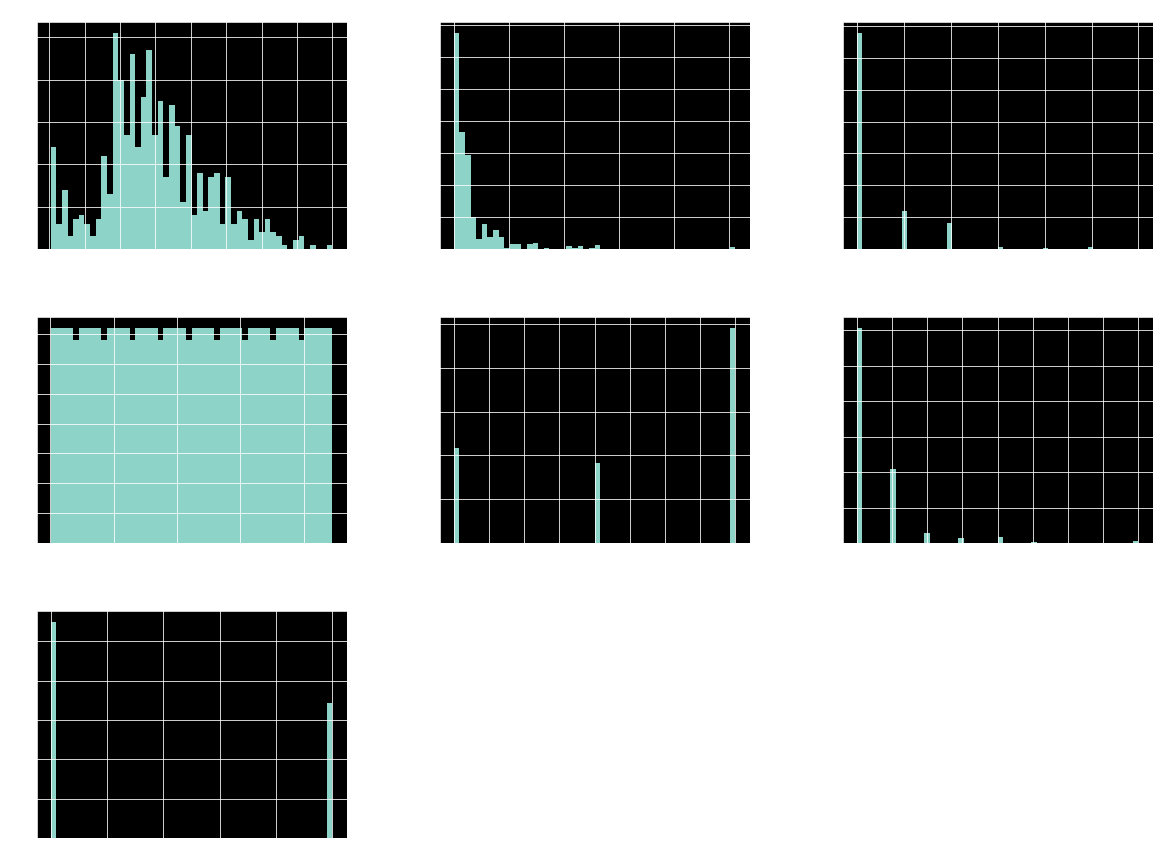

In [6]:
train_df.hist(bins=50, figsize=(20,15)) 
plt.show()

In [7]:
train_df.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Calderhead, Mr. Edward Pennington",male,1601,G6,S
freq,1,577,7,4,644


Explanation of features:

|Variable | Definition | Key |
|---------|------------|-----|
|survival | Survival | 0 = No, 1 = Yes| 
|pclass |Ticket class |1 = 1st, 2 = 2nd, 3 = 3rd |
|sex |Sex| |
|Age| Age in years| |
|sibsp |# of siblings / spouses aboard the Titanic||
|parch | # of parents / children aboard the Titanic||
|ticket |Ticket number ||
|fare |Passenger fare||
|cabin |Cabin number||
|embarked |Port of Embarkation |C = Cherbourg, Q = Queenstown, S = Southampton|



We can infer that some features will be useless such as name, ticket, cabin, and passenger ID. We can also infer that the harbor the passenger embarked from is not a good predictor for his/her survival.

I would guess that the most important predictors will be sex and age plus maybe the economical status proxied by the fare/ticket class

Probably it would be a good idea to make age categorical, something like baby,kid,young adult, adult, elderly. Age has some missing values, we will try to fill them with different strategies.

Same thing for fare, we could create 3 or 4 categories.


Let's create a copy for EDA and for playing with features:

In [8]:
train = train_df.copy()

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Age, dtype: object

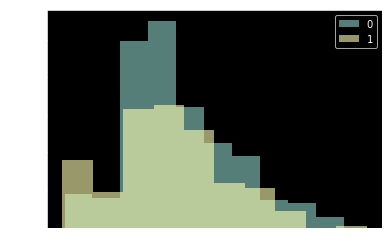

In [9]:
train.groupby("Survived").Age.plot(kind = "hist", legend = True, alpha = 0.6)

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Fare, dtype: object

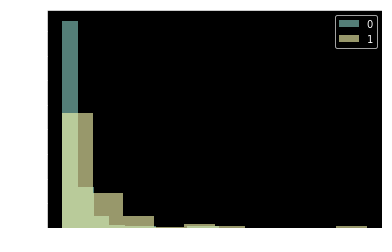

In [10]:
train.groupby("Survived").Fare.plot(kind = "hist", legend = True, alpha = 0.6)

We can see some patterns for age and fare: young children (age <10) survive more while young adults (age between 20 and 30) are not so lucky.
Based on this plot we could categorize ages like this:

- 0-10 
- 11-30
- 31-50
- 51-80

For fares it is economy vs more expensive tickes, we should try to find a good threshold

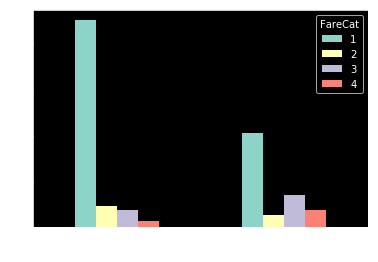

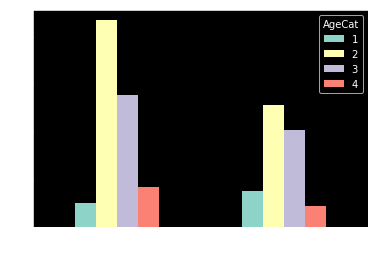

In [26]:
# make fare categorical
train["FareCat"] = pd.cut(train["Fare"], bins = [-np.inf, 30.0, 50.0, 100.0, np.inf], labels = [1, 2, 3, 4])
train.groupby(["Survived","FareCat"]).size().unstack().plot(kind='bar')
# make age categorical
train["AgeCat"] = pd.cut(train["Age"], bins = [-np.inf, 10.0, 30.0, 50.0, np.inf], labels = [1, 2, 3, 4])
train.groupby(["Survived","AgeCat"]).size().unstack().plot(kind='bar')

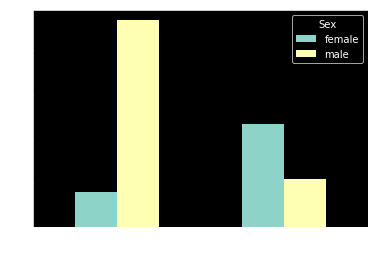

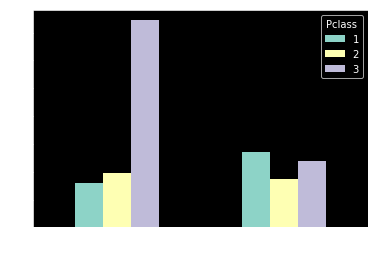

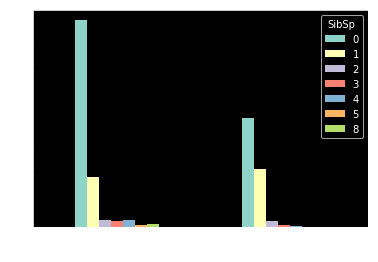

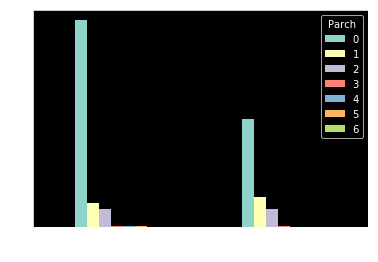

In [12]:
# exploratory plots for categorial variables
train.groupby(["Survived","Sex"]).size().unstack().plot(kind='bar')
train.groupby(["Survived","Pclass"]).size().unstack().plot(kind='bar')
train.groupby(["Survived","SibSp"]).size().unstack().plot(kind='bar')
train.groupby(["Survived","Parch"]).size().unstack().plot(kind='bar')

Sex and Ticket class seem to be promising predictors while # of siblings/spouses and # of parents/children on board seem to be worthless for our task.


**remember that we have some missing values in Age** so let's create an imputer for all numerical features. It will fill missing values with the median of that feature.

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

X_train = train_df.drop(["Survived"], axis = 1)
y_train = train_df.Survived
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Note**:

The output of ColumnTransformer is a numpy array without column headers.

The order of these columns is decided by the column argument of each encoder passed to ColumnTransformer. 

For example: 

If we try to modify this dataframe:

|a|b|c|d|
|-|-|-|-|
|...|...|...|...|
|...|...|...|...|
|...|...|...|...|

and we feed it into this ColumnTransfomer instance:

     ColumnTransformer([
    ("first encoder", SomeEncoder(), ["b","d"]),
    ("drop", "drop", ["c"])    
    ], 
    remainder = "passthrough")
    
we will obtain this numpy array (without the header of course)

|b|d|a|
|-|-|-|
|...|...|...|
|...|...|...|
|...|...|...|

In [14]:
drop_cols = ["PassengerId", "Name", "Ticket", "Cabin", "Embarked"] # remove these cols
num_cols = ["Fare", "Age"] # impute these cols with median
sex_cols = ["Sex"]
def titaniCols(df, drop_c, num_c, sex_c):
    all_c = list(df.columns) # get all cols
    rest_c = [c for c in all_c if c not in drop_c + num_c + sex_c] # get rest of cols
    rem_c = num_c + sex_c + rest_c # all cols remaining after processing
    return rem_c

tot_cols = titaniCols(X_train, drop_cols, num_cols, sex_cols)

coltrans = ColumnTransformer([
    ("median", SimpleImputer(strategy = "median"), num_cols),
    ("Sex", OrdinalEncoder(), sex_cols),
    ("drop", "drop", drop_cols)
], 
    remainder = "passthrough")

check = coltrans.fit_transform(X_train)

check_df = pd.DataFrame(data = check, columns = tot_cols)
check_df.head()

,Fare,Age,Sex,Pclass,SibSp,Parch
0,7.2500,22.0,1.0,3.0,1.0,0.0
1,71.2833,38.0,0.0,1.0,1.0,0.0
2,7.9250,26.0,0.0,3.0,0.0,0.0
3,53.1000,35.0,0.0,1.0,1.0,0.0
4,8.0500,35.0,1.0,3.0,0.0,0.0


In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
class TitaniCat(BaseEstimator, TransformerMixin):
    """
    This encoder transforms Fare and Age in the Titanic dataset into categorical variables.
    
    It's quick and dirty and specific for this analysis, don't judge!
    """
    def __init__(self, Xcols):
        """
        To initialize the transformer the a list of the columns is needed,
        because the transformer will get a numpy array as input and will need to use pd.DataFrame methods
        """
        self.Xcols = Xcols
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = pd.DataFrame(data = X, columns = self.Xcols) # transform the nparray into a dataframe
        df["Fare"] = pd.cut(df["Fare"], bins = [-np.inf, 30.0, 50.0, 100.0, np.inf], labels = [1, 2, 3, 4])
        df["Age"] = pd.cut(df["Age"], bins = [-np.inf, 10.0, 30.0, 50.0, np.inf], labels = [1, 2, 3, 4])
        return df

categorize = TitaniCat(Xcols = tot_cols)

check_df = categorize.fit_transform(check)
check_df.head()

,Fare,Age,Sex,Pclass,SibSp,Parch
0,1,2,1.0,3.0,1.0,0.0
1,3,3,0.0,1.0,1.0,0.0
2,1,2,0.0,3.0,0.0,0.0
3,3,3,0.0,1.0,1.0,0.0
4,1,3,1.0,3.0,0.0,0.0


In [16]:
data_prep = Pipeline([("a", coltrans), ("b", categorize)])
X_prepared = data_prep.fit_transform(X_train)
X_prepared.head()

,Fare,Age,Sex,Pclass,SibSp,Parch
0,1,2,1.0,3.0,1.0,0.0
1,3,3,0.0,1.0,1.0,0.0
2,1,2,0.0,3.0,0.0,0.0
3,3,3,0.0,1.0,1.0,0.0
4,1,3,1.0,3.0,0.0,0.0


In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
rf_class = RandomForestClassifier()

In [27]:
%time lr_scores = cross_val_score(log_reg, X_prepared, y_train, scoring = "accuracy", cv = 10)
lr_scores

Wall time: 70 ms


array([0.81111111, 0.77777778, 0.7752809 , 0.80898876, 0.79775281,
       0.75280899, 0.76404494, 0.7752809 , 0.83146067, 0.79545455])

In [28]:
%time rf_scores = cross_val_score(rf_class, X_prepared, y_train, scoring = "accuracy", cv = 10)
rf_scores

Wall time: 148 ms


array([0.73333333, 0.82222222, 0.76404494, 0.84269663, 0.85393258,
       0.76404494, 0.78651685, 0.7752809 , 0.86516854, 0.80681818])